<h1>Preparing SafeGraph monthly-patterns data with Python and sqlite3</h1>

This demo shows how to get started with SafeGraph's social-distancing data using sqlite3, a Python package for working with SQLite. This is just one of many possible ways to work with such a large data set. This approach requires a little extra time up front to put the compressed CSV files into SQLite files, but saves time later by making the data faster to filter. Be aware, this approach also takes up more storage.

Data documentation and other resources: https://docs.google.com/spreadsheets/d/1UNWvPzkUTTlXBZ6M6iGhM_7sr8h-MxsZdE7iOszkAmk/edit#gid=0

<h2>Steps</h2>
<ol>
<li><b>Download Data</b> - Before starting with anything in Python, you first need to download the data from S3. See <a href = "https://safegraphcovid19.slack.com/archives/C0109NPA543/p1585177965017700">this Slack post</a> for details. This demo only includes the <b>monthly-patterns</b> data. There is a similar demo for the <b>social-distancing</b> data.</li>

<li><b>Organize Directories</b> - I recommend placing this file in a folder called 'social-distancing-sqlite-files' (or something similar) within a your SafeGraph directory. For example, mine is <code>C:/Users/Kruse/Desktop/SafeGraph/monthly-patterns-sqlite-files/this_file.ipynb</code>. This script will create a bunch of SQLite files in the same directory (one for each month), so it's nice to have them in a different folder.</li>

<li><b>Setup</b> - Run the import statements and define the functions as seen below. You may need to install packages.</li>

<li><b>Create SQLite Files</b> - Be sure to update the file path according to your setup before running the code. This step will take time because the script goes through each compressed CSV file and stores the data in an SQLite file, but it saves time later when querying the data.</li>

<li><b>Query Data</b> - After the SQLite files have been created, you are ready to start querying the data! See below for instructions.</li>
</ol>


<h3>Setup</h3>

In [24]:
import pandas as pd
import sqlite3
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [14]:
def getAllCompressedCSVFiles(f_path):
    subdirs = [x[0] for x in os.walk(f_path)]
    all_f = {}
    for p in subdirs:
        fs = glob.glob(os.path.join(p + "\\","*.csv.gz"))
        if len(fs) > 0:
            all_f[p[-7:].replace('\\','-')] = fs
    return(all_f)

# assumes SQLite DB does not already exist of this name, otherwise it will just append to existing, leading to duplicates
def makeNewSQLite(name, files):
    conn = sqlite3.connect(name + '.sqlite')
    files.reverse()
    for f_path in files:
        print(f_path)
        for c in tqdm(pd.read_csv(f_path, chunksize=100000)):
              c.to_sql(name, conn, if_exists='append')
    print(name+'.sqlite done')
    conn.close()

#makes monthly SQLite files for specified months in specified folder
def makeMonthlySQLiteFiles(f_path, months=['01','02','03','04','05','06','07','08','09','10','11','12']):
    files = getAllCompressedCSVFiles(f_path)
    keys = list(files.keys())
    keys.reverse()
    for k in keys:
        if k[5:7] in months:
            print(k)
            makeNewSQLite(k,files[k])
        
def queryToDF(select_columns, conditions, months):
    c = 0
    for m in tqdm(months):
        conn = sqlite3.connect(m + '.sqlite')
        select_string = ''
        for x in range(len(select_columns)):
            select_string += '"' + select_columns[x] + '"'
            if x != len(select_columns)-1:
                select_string += ','
        q = 'SELECT ' + select_string + ' FROM "' + m + '" ' + conditions
        print("QUERY:", q)
        temp_df = pd.read_sql_query(q, conn)
        if c == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
        c += 1
        conn.close()
    return(df)

#add some columns to your dataframe that make filtering and visualizations easier
def addColumns(df):
    df['month'] = [str(x)[0:7] for x in df['date_range_start']] #create month column
    return(df)

<h3>Create SQLite Files</h3>

<b>TODO:</b> 
<ol>
    <li>Update <code>f_path</code> argument to match your setup and desired year</li>
    <li>Update <code>months</code> argument to your desired months (default is all months)
    <ul><li>As you can see, <code>months</code> is set to include only March and April - adding <code>'01'</code> to the list will include January, adding <code>'02'</code> will include February, etc</li></ul>
    </li>
</ol>
The file path ending in <code>social-distancing/<b>2020</b></code> will make SQLite files for all months in 2020. Switch to <code>social-distancing/<b>2019</b></code> for 2019.

<b>This step will take some time, so if you only want to work with January 2020 - March 2020 data, you should set the parameters accordingly.</b> It took me about 12 minutes per month on my not-very-fancy laptop.

<b>Important:</b> These SQLite files are stored in the same directory as this script. If you run this function and one or more of the SQLite files already exists, Python will add onto the existing SQLite files. This means the data will be duplicated. If needed, you can delete SQLite files and run this function to remake them. You should only have to run this function one time for each month of data you want to work with to avoid duplicating data.

In [16]:
makeMonthlySQLiteFiles("C:\\Users\\Kruse\\Desktop\\SafeGraph\\data\\monthly-patterns\\patterns_backfill\\2020", months = ['03','04'])

2020-04
C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\04\patterns-part4.csv.gz


10it [01:13,  7.33s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\04\patterns-part3.csv.gz


10it [01:21,  8.18s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\04\patterns-part2.csv.gz


10it [01:39,  9.94s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\04\patterns-part1.csv.gz


11it [02:14, 12.24s/it]


2020-04.sqlite done
2020-03
C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\03\patterns-part4.csv.gz


11it [01:33,  8.49s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\03\patterns-part3.csv.gz


11it [01:38,  8.99s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\03\patterns-part2.csv.gz


11it [01:56, 10.60s/it]


C:\Users\Kruse\Desktop\SafeGraph\data\monthly-patterns\patterns_backfill\2020\03\patterns-part1.csv.gz


11it [01:58, 10.78s/it]


2020-03.sqlite done


<h3>Query Data</h3>
<ol>
<li>Set <code>select_columns</code> variable to be a list of the columns you want to return. See documentation for columns list and details <a href ='https://docs.safegraph.com/docs/places-schema#section-patterns'>here</a>.</li>

<li>Set the conditions for your query. This example filters results to those from Mankato, MN.</li>

<li>Set the months variable to be a list of the months you want to include in your query. This example only includes results from March and April of 2020.
    <ul><li>Remember: You can only query months that you made SQLite files for in the previous step.</li></ul>
</li>

<li>The results of your query are stored as a dataframe in the df variable.</li>
</ol>
<b>Tip:</b> Filter to only take what you need. Larger queries will take longer to execute (this one took just about 10.5 minutes on my not-very-fancy laptop). Additionally, larger data frames will take longer to analyze.

In [17]:
select_columns = ['location_name', 'street_address', 'city', 'region', 'postal_code', 'date_range_start', 'date_range_end', 'median_dwell']
conditions = 'WHERE "city"="Mankato" AND "region"="MN"'
months = ['2020-03','2020-04']
df = queryToDF(select_columns, conditions, months)
df = addColumns(df)
df

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

QUERY: SELECT "location_name","street_address","city","region","postal_code","date_range_start","date_range_end","median_dwell" FROM "2020-03" WHERE "city"="Mankato" AND "region"="MN"


 50%|█████████████████████████████████████████▌                                         | 1/2 [04:23<04:23, 263.40s/it]

QUERY: SELECT "location_name","street_address","city","region","postal_code","date_range_start","date_range_end","median_dwell" FROM "2020-04" WHERE "city"="Mankato" AND "region"="MN"


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:59<00:00, 209.53s/it]


,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,median_dwell,month
0,Social Security,12 Civic Cntr Plaza Ste 1550 Mankato Pl,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,32.0,2020-03
1,Weight Watchers,421 E Hickory St,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,61.5,2020-03
2,Shogun Sushi And Hibachi,1901 Madison Ave Ste 315,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,32.0,2020-03
3,The Loose Moose Saloon & Conference Center,119 S Front St,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,77.0,2020-03
4,Leep,929 N 4th St,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,39.0,2020-03
...,...,...,...,...,...,...,...,...,...
1651,Tq Nails,1901 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,20.0,2020-04
1652,Ferrellgas,21665 594th Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,22.0,2020-04
1653,Family Dollar Stores,818 S Front St,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,12.0,2020-04
1654,Perkins Restaurant & Bakery,1790 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,9.5,2020-04


<h3>Example</h3>
The following code blocks demonstrate a very simple use case.

In [19]:
#view the resulting pandas dataframe's chain coffee shops
tdf = df[df.location_name.isin(['Starbucks','Caribou Coffee','Dunkin\''])]
tdf

,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,median_dwell,month
148,Starbucks,1872 Madison Ave,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,8.0,2020-03
193,Caribou Coffee,1580 Madison Ave,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,9.0,2020-03
211,Dunkin',1701 Madison Ave,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,6.5,2020-03
262,Caribou Coffee,1800 Madison Ave,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,9.0,2020-03
409,Caribou Coffee,1901 Madison Ave,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,20.5,2020-03
705,Caribou Coffee,1680 Warren St,Mankato,MN,56001,2020-03-01T00:00:00-06:00,2020-04-01T00:00:00-05:00,8.0,2020-03
989,Caribou Coffee,1580 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,7.0,2020-04
1029,Caribou Coffee,1800 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,26.0,2020-04
1222,Caribou Coffee,1901 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,13.0,2020-04
1231,Dunkin',1701 Madison Ave,Mankato,MN,56001,2020-04-01T00:00:00-05:00,2020-05-01T00:00:00-05:00,6.0,2020-04


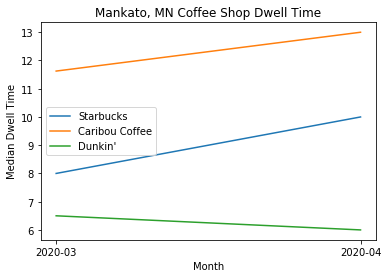

In [33]:
for x in list(tdf.location_name.unique()):
    plt.plot(tdf[tdf['location_name']==x].groupby('month')['median_dwell'].mean(), label=x)
    
plt.xlabel("Month")
plt.ylabel("Median Dwell Time")
plt.title("Mankato, MN Coffee Shop Dwell Time")
plt.legend()

<h3>Practice</h3>

Adjust the code to see how Mankato's chain coffee shops' median dwell time and number of visitors has (or has not) changed from January 2020 to April 2020.